In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ds(x, y, x_dot, y_dot, paths, title_name, x_targets=None):
    """
    Plots a 2D dynamical system, velocity field, and trajectories.
    
    Parameters:
    x, y: Meshgrid coordinates
    x_dot, y_dot: Velocity components at meshgrid points
    paths: List of 2xN arrays, where each array is a trajectory
    title_name: String title for the plot
    x_targets: Optional list of target points to plot
    """
    plt.figure(figsize=(10, 8))
    
    # Calculate velocity magnitude for coloring
    vel_mag = np.sqrt(x_dot**2 + y_dot**2)
    
    # Plot contours
    plt.contourf(x, y, vel_mag, 50, cmap='summer', alpha=0.6)
    cbar = plt.colorbar()
    cbar.set_label('Absolute Velocity', fontsize=12)
    
    # Plot streamlines
    plt.streamplot(x, y, x_dot, y_dot, color='k', density=1.5, linewidth=0.5, arrowsize=1)
    
    # Plot trajectories
    if paths:
        for p in paths:
            plt.plot(p[0, :], p[1, :], 'r-', linewidth=2, label='Trajectory')
            plt.plot(p[0, 0], p[1, 0], 'r*', markersize=12, label='Start') # Start
            
    # Plot targets
    if x_targets is not None:
        for t in x_targets:
            plt.plot(t[0], t[1], 'bd', markersize=10, markeredgecolor='k', label='Attractor')

    plt.title(title_name, fontsize=16)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14)
    plt.xlim([np.min(x), np.max(x)])
    plt.ylim([np.min(y), np.max(y)])
    plt.grid(True)
    plt.show()

print("Setup Complete.")

Setup Complete.


## Exercise 1.1: Modulated Linear Dynamical System
**Goal:** Consider a 2D linear DS $\dot{x} = Ax$ with $x(0) = [1, 1]^T$. We introduce a modulation matrix $M$ such that $\dot{x} = M A x$.
Given $M = \begin{bmatrix} 1 & -2 \\ 0 & 1 \end{bmatrix}$.

**Task:**
1.  Find a diagonal matrix $A = \text{diag}(a_1, a_2)$ with $a_1 \neq a_2$ such that the system converges to $[0,0]^T$.
2.  Compute and plot the path integral and the the vector field over the grid.

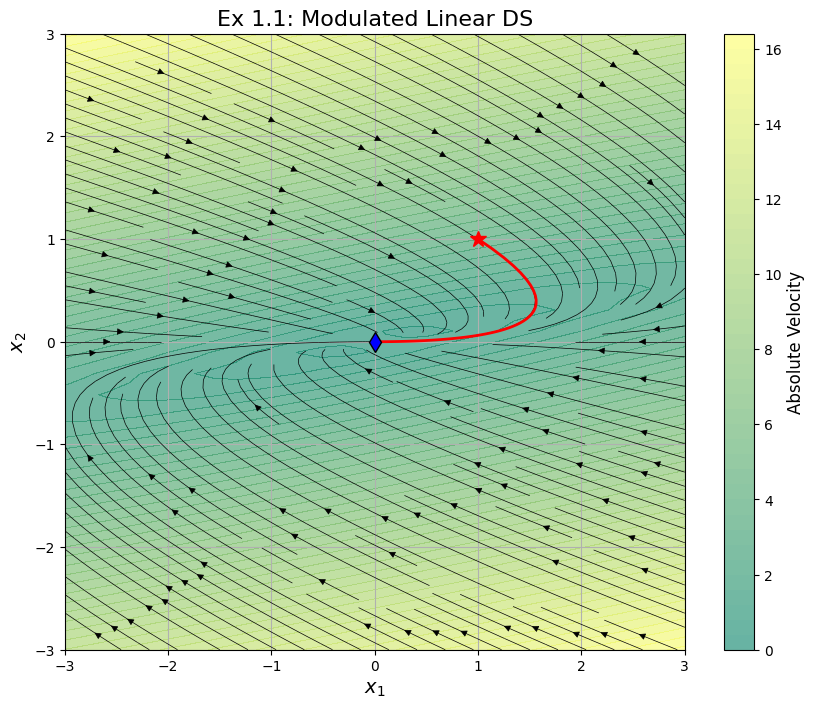

In [6]:
def exercise_1_1():
    # 1. Define Grid
    x_limits = [-3, 3]
    y_limits = [-3, 3]
    nb_gridpoints = 30
    x_vals = np.linspace(x_limits[0], x_limits[1], nb_gridpoints)
    y_vals = np.linspace(y_limits[0], y_limits[1], nb_gridpoints)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    # 2. Define Matrices
    # M is given
    M = np.array([[1, -2], 
                  [0,  1]])
    
    # Define A such that the system is stable
    # Requirement: a1 != a2
    A = np.array([[-1, 0], 
                  [0, -2]]) # <--- CHANGE THIS

    # 3. Compute Vector Field (x_dot, y_dot) over the grid
    # System: dx = M * A * x
    UV = np.zeros(X.shape + (2,))
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_curr = np.array([X[i,j], Y[i,j]])
             
            x_dot_vec = M @ A @ x_curr 
            
            UV[i, j, 0] = x_dot_vec[0]
            UV[i, j, 1] = x_dot_vec[1]
            
    x_dot = UV[:,:,0]
    y_dot = UV[:,:,1]

    # 4. Path Integration
    dt = 0.05
    max_iter = 1000
    x0 = np.array([1.0, 1.0]) # Start position
    
    path = [x0]
    curr_x = x0.copy()
    
    for _ in range(max_iter):
        k1 = dt * (M @ A @ curr_x)
        k2 = dt * (M @ A @ (curr_x + 0.5 * k1))
        k3 = dt * (M @ A @ (curr_x + 0.5 * k2))
        k4 = dt * (M @ A @ (curr_x + k3))
        curr_x = curr_x + (k1 + 2*k2 + 2*k3 + k4) / 6
        path.append(curr_x.copy())
        
        # Stop if close to zero
        if np.linalg.norm(curr_x) < 0.01:
            break
            
    path = np.array(path).T # Convert to 2xN for plotting

    # 5. Plot
    plot_ds(X, Y, x_dot, y_dot, [path], "Ex 1.1: Modulated Linear DS", [np.zeros(2)])

exercise_1_1()

## Exercise 1.4: Pendulum with & without Friction
**Goal:**
1.  Model the pendulum dynamics: $\ddot{\theta} = -g \sin(\theta) - \lambda \dot{\theta}$ (where $\lambda$ is friction).
2.  State space $x = [x_1, x_2]^T = [\theta, \dot{\theta}]^T$.
3.  Simulate and plot trajectories for various start points.

**Cases:**
* Case A: No Damping ($\lambda = 0$)
* Case B: With Damping ($\lambda = 1.0$)

**Start Points:**
$x_0 \in \{ [0,0]^T, [0.78, 0]^T, [2.35, 0]^T, [3.14, 1]^T, [3.14, 4]^T \}$

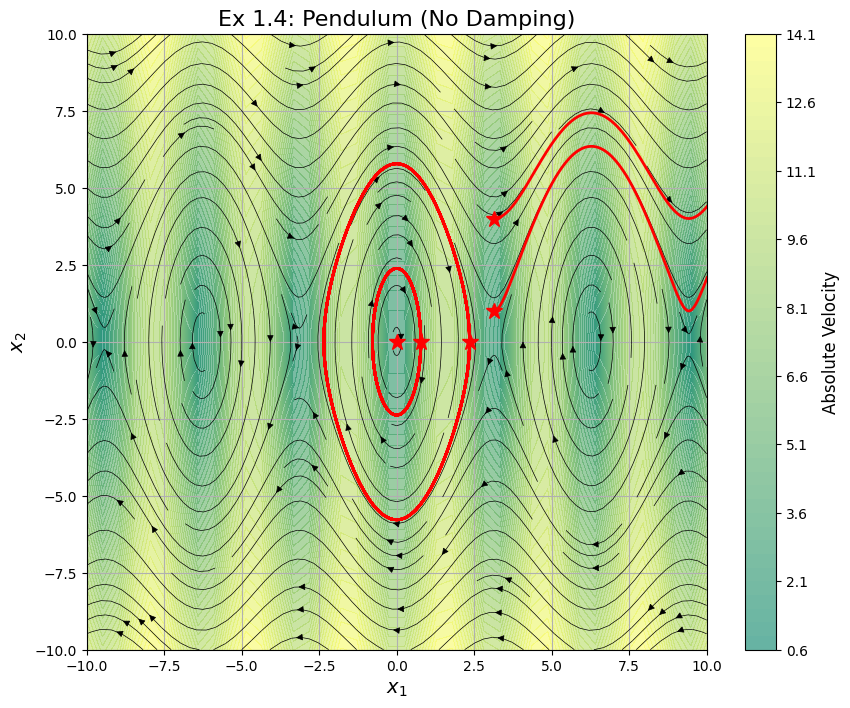

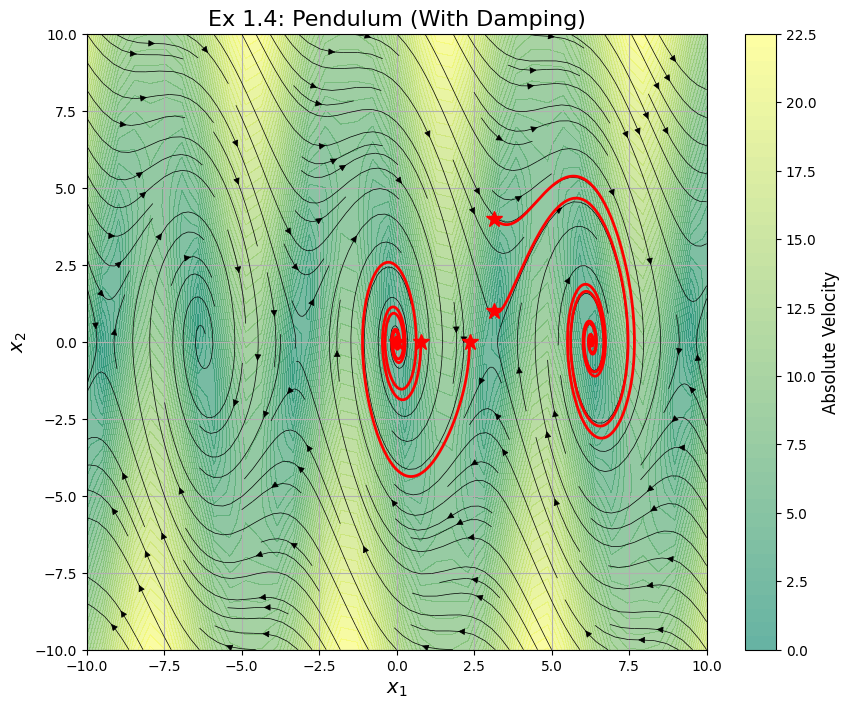

In [7]:
def exercise_1_4():
    # 1. Define Grid
    x_limits = [-10, 10] # Theta
    y_limits = [-10, 10] # Theta_dot
    nb_gridpoints = 40
    X, Y = np.meshgrid(np.linspace(x_limits[0], x_limits[1], nb_gridpoints),
                       np.linspace(y_limits[0], y_limits[1], nb_gridpoints))
    
    g = 9.81
    
    # List of start positions given in assignment
    start_points = [
        np.array([0.0, 0.0]),
        np.array([0.78, 0.0]),
        np.array([2.35, 0.0]),
        np.array([3.14, 1.0]),
        np.array([3.14, 4.0])
    ]

    # --- FUNCTION TO SIMULATE AND PLOT ---
    def run_pendulum(damping_coeff, title):
        # A. Compute Vector Field
        UV = np.zeros(X.shape + (2,))
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                theta = X[i,j]
                theta_dot = Y[i,j]
                
                # Implement Pendulum Dynamics
                x1_dot = theta_dot
                x2_dot = -g * np.sin(theta) - damping_coeff * theta_dot
                
                
                UV[i,j,0] = x1_dot
                UV[i,j,1] = x2_dot
        
        # B. Integrate Trajectories
        paths = []
        dt = 0.01
        max_iter = 2000
        
        for x0 in start_points:
            path = [x0]
            curr_x = x0.copy()
            for _ in range(max_iter):
                # RK4 integration
                k1 = dt * np.array([curr_x[1], -g * np.sin(curr_x[0]) - damping_coeff * curr_x[1]])
                k2 = dt * np.array([curr_x[1] + 0.5 * k1[1], -g * np.sin(curr_x[0] + 0.5 * k1[0]) - damping_coeff * (curr_x[1] + 0.5 * k1[1])])
                k3 = dt * np.array([curr_x[1] + 0.5 * k2[1], -g * np.sin(curr_x[0] + 0.5 * k2[0]) - damping_coeff * (curr_x[1] + 0.5 * k2[1])])
                k4 = dt * np.array([curr_x[1] + k3[1], -g * np.sin(curr_x[0] + k3[0]) - damping_coeff * (curr_x[1] + k3[1])])
                curr_x = curr_x + (k1 + 2*k2 + 2*k3 + k4) / 6
                
                path.append(curr_x.copy())
                
            paths.append(np.array(path).T)
            
        plot_ds(X, Y, UV[:,:,0], UV[:,:,1], paths, title)

    # Run Case A: No Damping
    run_pendulum(damping_coeff=0.0, title="Ex 1.4: Pendulum (No Damping)")
    
    # Run Case B: With Damping
    run_pendulum(damping_coeff=1.0, title="Ex 1.4: Pendulum (With Damping)")

exercise_1_4()